# CMI - EDA on actigraphy data

In [1]:
import numpy as np
import pandas as pd
import re
import glob 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('xtick',labelsize=12)
plt.rc('ytick',labelsize=12)

sns.set_theme()

import warnings
warnings.filterwarnings('ignore')

In [2]:
folder_path = './../child-mind-institute-problematic-internet-use/'
series_train_path = folder_path + 'series_train.parquet/id='
train_df = pd.read_csv(folder_path + 'train.csv')

The participant IDs in the ```series_train.parquet``` folder are extracted into the list ```series_train_ids```.

In [3]:
series_train_folders = glob.glob(folder_path + 'series_train.parquet/*')

def extract_series_id(folder_list):
    id_list = []
    for n, folder in enumerate(folder_list):
        id = folder.split('=')[-1]
        id_list.append(id)

    return id_list 

series_train_ids = extract_series_id(series_train_folders)

The parquet files have the following fields -
* ```id``` - the participant identifier code corresponding to those in ```train.csv``` and ```test.csv```
* ```step``` - integer steps indicating progession on time in the series
* ```X```, ```Y``` and ```Z``` - acceleration measurements in units of $g$ along the three spatial dimensions $x$, $y$ and $z$
* ```enmo``` - described in the ```wristpy``` package as ENMO (Euclidean Norm Minus One) of all the accelerometer signals with negative values rounded off to zero; zero ENMO values indicate periods of no motion
* ```anglez``` - described in the ```wristpy``` package as Angle-Z, the angle of the wrist relative to the horizontal plane

Both ```enmo``` and ```anglez``` can be used to identify periods of little or not activity.

* ```non-wear_flag``` - a flag denoting whether or not the actimeter is worn (labeled as 1) or not (labeled 0)
* ```light``` - measurement of ambient light given in lux

```light``` can be used to determine different times of day (day vs. night) and different types of activities (indoors vs. outdoors).

* ```battery_voltage``` - battery voltage in mV
* ```time_of_day``` - time of day representing the start of a $5\:\rm{s}$ window that the data has been sampled over, with format ```%H:%M:%S.%9f```
* ```weekday``` - day of the week in integers (not encodeded, so difficult to tell which integer corresponds to the start of the week)
* ```quarter``` - quarter of the year as integer between 1 and 4
* ```relative_data_PCIAT``` - the number of days since the PCIAT test was administered

## Sample actigraphy readings

Below is the actigraphy readings of participant ```0d01bbf2```. Matching this ID with the training dataset, we find that this corresponds to a 9 year old boy. Let us look at some of data collected on him -
* Weight of $90\:\rm{lb}$, height of $57\:\rm{in}$ with a BMI of $19.6$ which is indicative of normal weight
* Blood pressure in the normal range $114/76\:\rm{mm/Hg}$
* The data suggests that we uses the internet less an one hour everyday, thus a zero severity index
* A ```CGAS``` of 55 indicates 'Variable functioning with sporadic difficulties or symptoms in several but not all social areas', indicating impairement in daily function in several aspects

In [4]:
sample_series = pd.read_parquet(series_train_path + series_train_ids[0])

sample_series.head()

,step,X,Y,Z,enmo,anglez,non-wear_flag,light,battery_voltage,time_of_day,weekday,quarter,relative_date_PCIAT
0,0,-0.468869,0.412020,-0.236458,0.042506,-19.824650,0.0,27.666666,4179.000000,57480000000000,4,1,28.0
1,1,-0.662526,0.533484,0.064034,0.052847,4.300246,0.0,12.666667,4178.666504,57485000000000,4,1,28.0
2,2,-0.611384,0.227252,-0.150882,0.060734,-16.545208,0.0,47.000000,4178.333496,57490000000000,4,1,28.0
3,3,-0.385799,0.552782,-0.500523,0.070440,-36.452175,0.0,63.799999,4178.000000,57495000000000,4,1,28.0
4,4,0.016133,0.031981,-0.825109,0.081058,-67.488388,0.0,6.000000,4177.666504,57500000000000,4,1,28.0


In [21]:
train_df[train_df['id'] == '0d01bbf2']

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,...,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii
230,0d01bbf2,Fall,9,0,Spring,55.0,Winter,19.603509,57.0,90.6,...,1.0,1.0,1.0,11.0,Winter,32.0,46.0,Fall,0.0,0.0


In [36]:
''' 
Function for plotting ENMO, Angle-Z, Light and one other feature.
'''

def plot_feature_series(
        data,
        col='non-wear_flag',
        label='Non-Wear Flag',
        title='Non-Wear Flag',
        x_col='day_time',
        x_label='Day Relative to PCIAT + Time'
):
    fig, ax = plt.subplots(4, 1, figsize=(18, 12), sharex=True)

    # ENMO
    ax[0].plot(data[x_col], data['enmo'], linewidth=0.5, c='r')
    ax[0].set_ylabel('ENMO', fontsize=15)
    ax[0].set_title('ENMO', fontsize=15)

    # Angle-Z
    ax[1].plot(data[x_col], data['anglez'], linewidth=0.5, c='g')
    ax[1].set_ylabel('Angle-Z', fontsize=15)
    ax[1].set_title('Angle-Z', fontsize=15)

    # Light
    ax[2].plot(data[x_col], data['light'], linewidth=0.5, c='b')
    ax[2].set_ylabel('Light intensity', fontsize=15)
    ax[2].set_title('Light intensity', fontsize=15)

    # Other
    ax[3].plot(data[x_col], data[col], linewidth=0.5, c='k')
    ax[3].set_xlabel(f'{x_label}', fontsize=15)
    ax[3].set_ylabel(f'{label}', fontsize=15)
    ax[3].set_title(f'{title}', fontsize=15)

    plt.show()

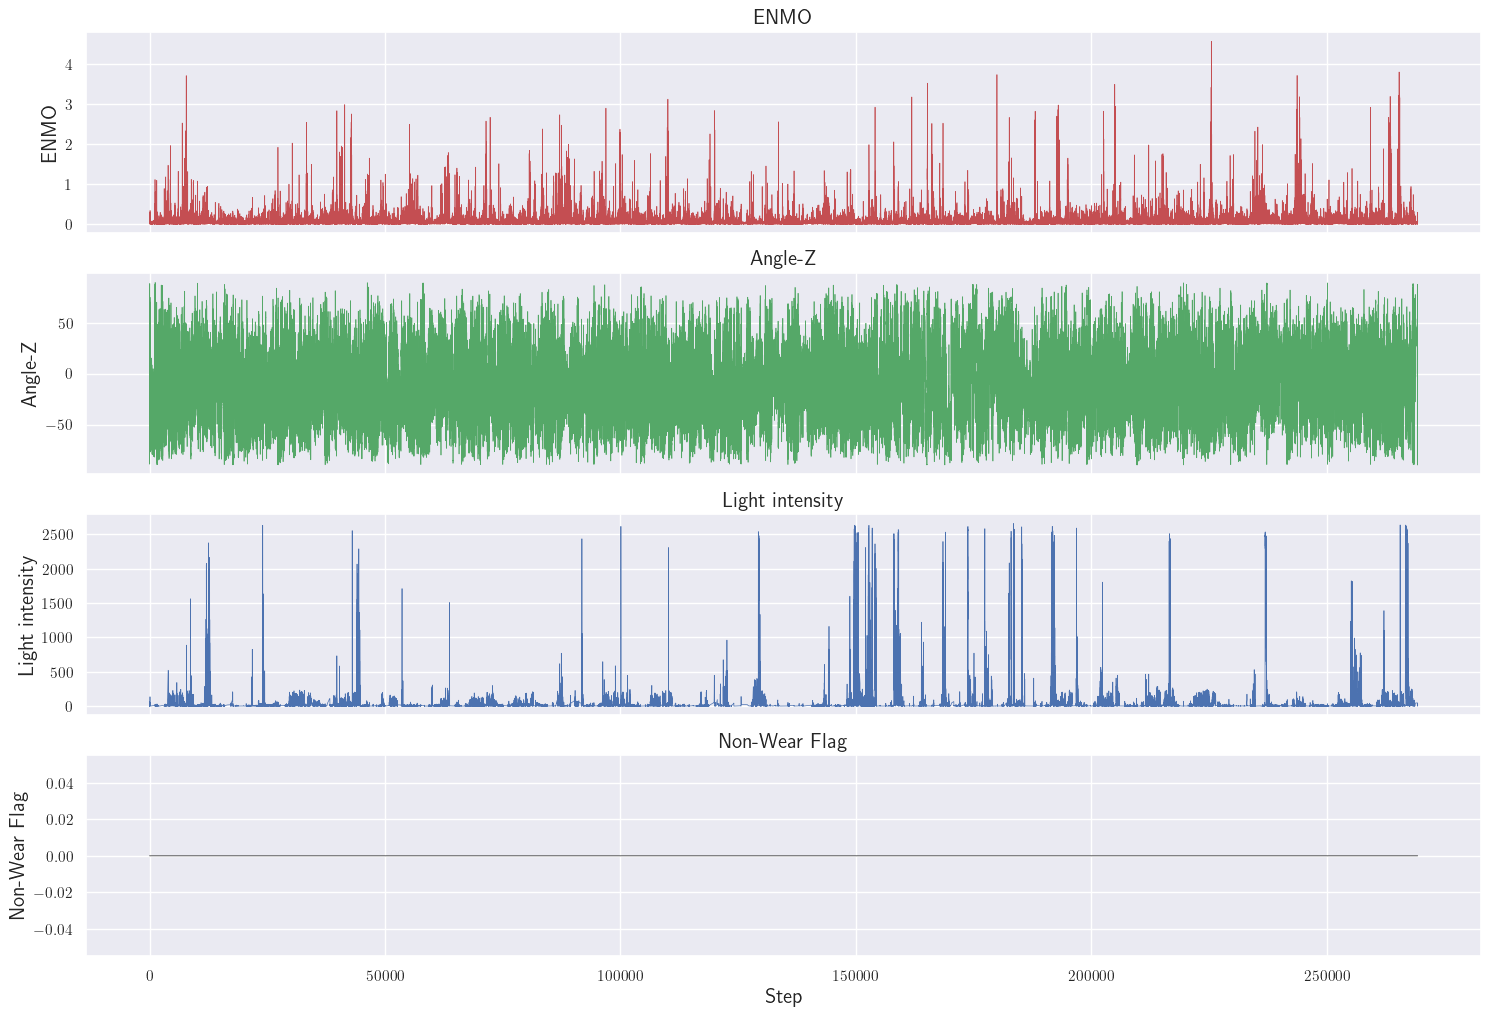

In [37]:
plot_feature_series(sample_series, x_col='step', x_label='Step')

We create a ```day_time``` column that converts the ```time_of_day``` feature to from nanoseconds to days and then combining it with ```relative_date_PCIAT```.

In [43]:
sample_series['time_of_day_hours'] = sample_series['time_of_day'] / 10**9 / 3600 

sample_series['day_time'] = sample_series['relative_date_PCIAT'] + sample_series['time_of_day_hours'] /24
sample_series['day_time']

0         28.665278
1         28.665336
2         28.665394
3         28.665451
4         28.665509
            ...    
269330    63.480613
269331    63.480671
269332    63.480729
269333    63.486111
269334    63.486169
Name: day_time, Length: 269335, dtype: float64

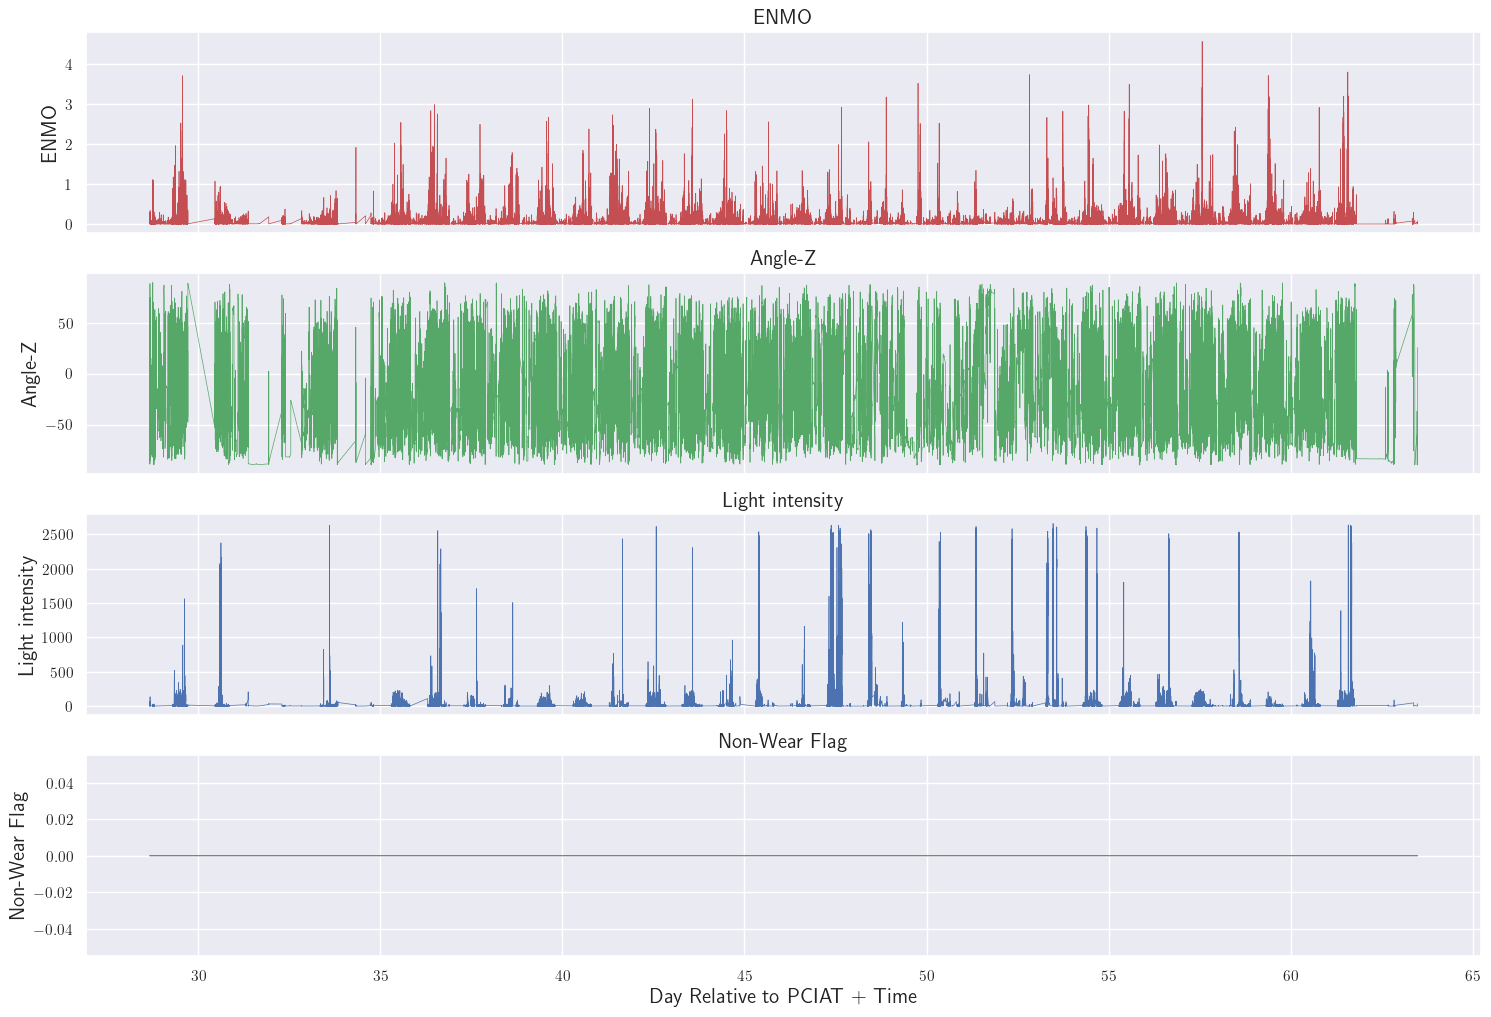

In [44]:
plot_feature_series(sample_series, x_col='day_time', x_label='Day Relative to PCIAT + Time')